In [8]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'

In [9]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [10]:
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

In [11]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [12]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')  # Initialize the best accuracy to negative infinity
    best_model_state = None  # Store the state of the best model
    best_epoch = 0  # Track the epoch with the best accuracy
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Best Model was saved at epoch {best_epoch} with accuracy {best_accuracy * 100:.2f}%")
    return custom_mlp, losses, best_accuracy

In [13]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]


In [14]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


OutOfMemoryError: CUDA out of memory. Tried to allocate 224.00 MiB. GPU 0 has a total capacity of 79.35 GiB of which 189.19 MiB is free. Process 1340726 has 68.49 GiB memory in use. Including non-PyTorch memory, this process has 10.67 GiB memory in use. Of the allocated memory 9.64 GiB is allocated by PyTorch, and 1.71 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [15]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")


Data successfully split into training and test sets.


Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/torch/autograd/graph.py:768: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training Epochs:   2%|▏         | 10/500 [00:03<01:52,  4.37it/s]

Epoch 10/500, Loss: 0.5606
Test Accuracy at Epoch 10: 51.98%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.50      0.83      0.63       283
non_infringement       0.58      0.22      0.32       298

        accuracy                           0.52       581
       macro avg       0.54      0.53      0.48       581
    weighted avg       0.54      0.52      0.47       581

New best model saved with accuracy 51.98% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.50      0.83      0.63       283
non_infringement       0.58      0.22      0.32       298

        accuracy                           0.52       581
       macro avg       0.54      0.53      0.48       581
    weighted avg       0.54      0.52      0.47       581



Training Epochs:   4%|▍         | 20/500 [00:06<03:17,  2.43it/s]

Epoch 20/500, Loss: 0.5081
Test Accuracy at Epoch 20: 64.37%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.75      0.41      0.53       283
non_infringement       0.61      0.87      0.71       298

        accuracy                           0.64       581
       macro avg       0.68      0.64      0.62       581
    weighted avg       0.67      0.64      0.62       581

New best model saved with accuracy 64.37% at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.75      0.41      0.53       283
non_infringement       0.61      0.87      0.71       298

        accuracy                           0.64       581
       macro avg       0.68      0.64      0.62       581
    weighted avg       0.67      0.64      0.62       581



Training Epochs:   6%|▌         | 30/500 [00:10<03:22,  2.32it/s]

Epoch 30/500, Loss: 0.5207
Test Accuracy at Epoch 30: 58.69%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.56      0.67      0.61       283
non_infringement       0.62      0.51      0.56       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.58       581



Training Epochs:   8%|▊         | 40/500 [00:15<03:34,  2.14it/s]

Epoch 40/500, Loss: 0.4916
Test Accuracy at Epoch 40: 63.68%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.69      0.46      0.55       283
non_infringement       0.61      0.80      0.69       298

        accuracy                           0.64       581
       macro avg       0.65      0.63      0.62       581
    weighted avg       0.65      0.64      0.63       581



Training Epochs:  10%|█         | 50/500 [00:16<00:44, 10.02it/s]

Epoch 50/500, Loss: 0.4650
Test Accuracy at Epoch 50: 67.47%
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.73      0.53      0.62       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.67       581
       macro avg       0.69      0.67      0.67       581
    weighted avg       0.69      0.67      0.67       581

New best model saved with accuracy 67.47% at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.73      0.53      0.62       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.67       581
       macro avg       0.69      0.67      0.67       581
    weighted avg       0.69      0.67      0.67       581



Training Epochs:  12%|█▏        | 60/500 [00:20<02:54,  2.53it/s]

Epoch 60/500, Loss: 0.4443
Test Accuracy at Epoch 60: 68.16%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.72      0.57      0.64       283
non_infringement       0.66      0.79      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.68      0.68       581

New best model saved with accuracy 68.16% at epoch 60
Best Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.72      0.57      0.64       283
non_infringement       0.66      0.79      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.68      0.68       581



Training Epochs:  14%|█▍        | 70/500 [00:22<01:11,  6.01it/s]

Epoch 70/500, Loss: 0.4250
Test Accuracy at Epoch 70: 66.09%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.67      0.59      0.63       283
non_infringement       0.65      0.73      0.69       298

        accuracy                           0.66       581
       macro avg       0.66      0.66      0.66       581
    weighted avg       0.66      0.66      0.66       581



Training Epochs:  16%|█▌        | 80/500 [00:26<02:00,  3.47it/s]

Epoch 80/500, Loss: 0.4061
Test Accuracy at Epoch 80: 67.13%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.69      0.60      0.64       283
non_infringement       0.66      0.74      0.70       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  18%|█▊        | 90/500 [00:29<02:23,  2.85it/s]

Epoch 90/500, Loss: 0.3891
Test Accuracy at Epoch 90: 64.03%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.64      0.59      0.62       283
non_infringement       0.64      0.68      0.66       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.64       581
    weighted avg       0.64      0.64      0.64       581



Training Epochs:  20%|█▉        | 99/500 [00:31<02:18,  2.90it/s]

Epoch 100/500, Loss: 0.3741
Test Accuracy at Epoch 100: 64.37%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.65      0.60      0.62       283
non_infringement       0.64      0.69      0.66       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.64       581
    weighted avg       0.64      0.64      0.64       581



Training Epochs:  22%|██▏       | 110/500 [00:38<04:26,  1.46it/s]

Epoch 110/500, Loss: 0.3603
Test Accuracy at Epoch 110: 62.31%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.62      0.57      0.60       283
non_infringement       0.62      0.67      0.65       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581



Training Epochs:  24%|██▍       | 120/500 [00:42<03:15,  1.94it/s]

Epoch 120/500, Loss: 0.4302
Test Accuracy at Epoch 120: 66.61%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.79      0.43      0.56       283
non_infringement       0.62      0.89      0.73       298

        accuracy                           0.67       581
       macro avg       0.70      0.66      0.64       581
    weighted avg       0.70      0.67      0.65       581



Training Epochs:  26%|██▌       | 130/500 [00:47<03:07,  1.97it/s]

Epoch 130/500, Loss: 0.3972
Test Accuracy at Epoch 130: 61.62%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.60      0.63      0.62       283
non_infringement       0.63      0.60      0.62       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581



Training Epochs:  28%|██▊       | 140/500 [00:50<01:06,  5.41it/s]

Epoch 140/500, Loss: 0.3760
Test Accuracy at Epoch 140: 65.06%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.65      0.61      0.63       283
non_infringement       0.65      0.69      0.67       298

        accuracy                           0.65       581
       macro avg       0.65      0.65      0.65       581
    weighted avg       0.65      0.65      0.65       581



Training Epochs:  30%|███       | 150/500 [00:54<02:44,  2.13it/s]

Epoch 150/500, Loss: 0.3529
Test Accuracy at Epoch 150: 66.44%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.71      0.53      0.60       283
non_infringement       0.64      0.80      0.71       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.66       581
    weighted avg       0.67      0.66      0.66       581



Training Epochs:  32%|███▏      | 160/500 [00:58<01:41,  3.34it/s]

Epoch 160/500, Loss: 0.3414
Test Accuracy at Epoch 160: 64.03%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.64      0.61      0.62       283
non_infringement       0.64      0.66      0.65       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.64       581
    weighted avg       0.64      0.64      0.64       581



Training Epochs:  34%|███▍      | 170/500 [01:03<02:51,  1.93it/s]

Epoch 170/500, Loss: 0.3321
Test Accuracy at Epoch 170: 61.79%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.62      0.57      0.59       283
non_infringement       0.62      0.67      0.64       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581



Training Epochs:  36%|███▌      | 180/500 [01:08<02:59,  1.78it/s]

Epoch 180/500, Loss: 0.3230
Test Accuracy at Epoch 180: 65.92%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.68      0.57      0.62       283
non_infringement       0.64      0.75      0.69       298

        accuracy                           0.66       581
       macro avg       0.66      0.66      0.66       581
    weighted avg       0.66      0.66      0.66       581



Training Epochs:  38%|███▊      | 190/500 [01:13<02:19,  2.23it/s]

Epoch 190/500, Loss: 0.3144
Test Accuracy at Epoch 190: 65.92%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.69      0.55      0.61       283
non_infringement       0.64      0.76      0.70       298

        accuracy                           0.66       581
       macro avg       0.66      0.66      0.65       581
    weighted avg       0.66      0.66      0.66       581



Training Epochs:  40%|████      | 200/500 [01:19<02:24,  2.07it/s]

Epoch 200/500, Loss: 0.4841
Test Accuracy at Epoch 200: 61.27%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.61      0.56      0.59       283
non_infringement       0.61      0.66      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.61       581
    weighted avg       0.61      0.61      0.61       581



Training Epochs:  42%|████▏     | 210/500 [01:23<02:28,  1.96it/s]

Epoch 210/500, Loss: 0.3250
Test Accuracy at Epoch 210: 65.75%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.73      0.47      0.57       283
non_infringement       0.62      0.83      0.71       298

        accuracy                           0.66       581
       macro avg       0.68      0.65      0.64       581
    weighted avg       0.68      0.66      0.65       581



Training Epochs:  44%|████▍     | 220/500 [01:29<02:25,  1.92it/s]

Epoch 220/500, Loss: 0.3227
Test Accuracy at Epoch 220: 64.37%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.64      0.61      0.62       283
non_infringement       0.65      0.68      0.66       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.64       581
    weighted avg       0.64      0.64      0.64       581



Training Epochs:  46%|████▌     | 229/500 [01:34<02:47,  1.62it/s]

Epoch 230/500, Loss: 0.3063


Training Epochs:  46%|████▌     | 230/500 [01:35<03:31,  1.28it/s]

Test Accuracy at Epoch 230: 65.75%
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.69      0.55      0.61       283
non_infringement       0.64      0.76      0.70       298

        accuracy                           0.66       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.66      0.65       581



Training Epochs:  48%|████▊     | 240/500 [01:40<01:57,  2.22it/s]

Epoch 240/500, Loss: 0.2972
Test Accuracy at Epoch 240: 65.58%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.68      0.55      0.61       283
non_infringement       0.64      0.75      0.69       298

        accuracy                           0.66       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.66      0.65       581



Training Epochs:  50%|█████     | 250/500 [01:44<01:48,  2.30it/s]

Epoch 250/500, Loss: 0.2901
Test Accuracy at Epoch 250: 65.23%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.68      0.55      0.61       283
non_infringement       0.64      0.75      0.69       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.65      0.65       581



Training Epochs:  52%|█████▏    | 260/500 [01:48<01:18,  3.07it/s]

Epoch 260/500, Loss: 0.2797
Test Accuracy at Epoch 260: 64.37%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.66      0.57      0.61       283
non_infringement       0.64      0.72      0.67       298

        accuracy                           0.64       581
       macro avg       0.65      0.64      0.64       581
    weighted avg       0.65      0.64      0.64       581



Training Epochs:  54%|█████▍    | 270/500 [01:54<03:01,  1.27it/s]

Epoch 270/500, Loss: 0.4631
Test Accuracy at Epoch 270: 62.82%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.64      0.53      0.58       283
non_infringement       0.62      0.72      0.67       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.62       581
    weighted avg       0.63      0.63      0.62       581



Training Epochs:  56%|█████▌    | 280/500 [02:01<02:28,  1.48it/s]

Epoch 280/500, Loss: 0.3439
Test Accuracy at Epoch 280: 67.47%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.63       283
non_infringement       0.65      0.78      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.67       581
    weighted avg       0.68      0.67      0.67       581



Training Epochs:  58%|█████▊    | 290/500 [02:05<01:33,  2.25it/s]

Epoch 290/500, Loss: 0.2934
Test Accuracy at Epoch 290: 64.03%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.63      0.63      0.63       283
non_infringement       0.65      0.65      0.65       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.64       581
    weighted avg       0.64      0.64      0.64       581



Training Epochs:  60%|██████    | 300/500 [02:09<01:26,  2.31it/s]

Epoch 300/500, Loss: 0.2829
Test Accuracy at Epoch 300: 65.58%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.68      0.56      0.61       283
non_infringement       0.64      0.75      0.69       298

        accuracy                           0.66       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.66      0.65       581



Training Epochs:  62%|██████▏   | 310/500 [02:14<01:24,  2.26it/s]

Epoch 310/500, Loss: 0.2727
Test Accuracy at Epoch 310: 64.20%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.66      0.55      0.60       283
non_infringement       0.63      0.72      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.64       581
    weighted avg       0.64      0.64      0.64       581



Training Epochs:  64%|██████▍   | 320/500 [02:18<01:17,  2.33it/s]

Epoch 320/500, Loss: 0.2634
Test Accuracy at Epoch 320: 64.54%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.66      0.56      0.61       283
non_infringement       0.64      0.72      0.68       298

        accuracy                           0.65       581
       macro avg       0.65      0.64      0.64       581
    weighted avg       0.65      0.65      0.64       581



Training Epochs:  66%|██████▌   | 330/500 [02:22<01:12,  2.33it/s]

Epoch 330/500, Loss: 0.2563
Test Accuracy at Epoch 330: 64.20%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.65      0.58      0.61       283
non_infringement       0.64      0.70      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.64       581
    weighted avg       0.64      0.64      0.64       581



Training Epochs:  68%|██████▊   | 340/500 [02:26<01:09,  2.31it/s]

Epoch 340/500, Loss: 0.2565
Test Accuracy at Epoch 340: 63.51%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.67      0.49      0.57       283
non_infringement       0.61      0.78      0.69       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581



Training Epochs:  70%|███████   | 350/500 [02:30<01:07,  2.22it/s]

Epoch 350/500, Loss: 0.2605
Test Accuracy at Epoch 350: 64.20%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.65      0.56      0.60       283
non_infringement       0.63      0.72      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.64       581
    weighted avg       0.64      0.64      0.64       581



Training Epochs:  72%|███████▏  | 360/500 [02:35<01:05,  2.13it/s]

Epoch 360/500, Loss: 0.2469
Test Accuracy at Epoch 360: 64.37%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.64      0.60      0.62       283
non_infringement       0.64      0.68      0.66       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.64       581
    weighted avg       0.64      0.64      0.64       581



Training Epochs:  74%|███████▍  | 370/500 [02:40<01:01,  2.11it/s]

Epoch 370/500, Loss: 0.2574
Test Accuracy at Epoch 370: 61.62%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.65      0.45      0.53       283
non_infringement       0.60      0.77      0.67       298

        accuracy                           0.62       581
       macro avg       0.63      0.61      0.60       581
    weighted avg       0.62      0.62      0.61       581



Training Epochs:  76%|███████▌  | 380/500 [02:46<01:05,  1.82it/s]

Epoch 380/500, Loss: 0.2375
Test Accuracy at Epoch 380: 64.20%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.65      0.58      0.61       283
non_infringement       0.64      0.70      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.64       581
    weighted avg       0.64      0.64      0.64       581



Training Epochs:  78%|███████▊  | 390/500 [02:51<01:06,  1.65it/s]

Epoch 390/500, Loss: 0.2845
Test Accuracy at Epoch 390: 64.03%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.70      0.45      0.55       283
non_infringement       0.61      0.82      0.70       298

        accuracy                           0.64       581
       macro avg       0.66      0.64      0.63       581
    weighted avg       0.66      0.64      0.63       581



Training Epochs:  80%|████████  | 400/500 [02:56<00:51,  1.93it/s]

Epoch 400/500, Loss: 0.2510
Test Accuracy at Epoch 400: 63.68%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.64      0.57      0.61       283
non_infringement       0.63      0.70      0.66       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.63       581
    weighted avg       0.64      0.64      0.64       581



Training Epochs:  82%|████████▏ | 410/500 [03:00<00:40,  2.24it/s]

Epoch 410/500, Loss: 0.2323
Test Accuracy at Epoch 410: 62.13%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.64      0.50      0.56       283
non_infringement       0.61      0.74      0.67       298

        accuracy                           0.62       581
       macro avg       0.63      0.62      0.61       581
    weighted avg       0.63      0.62      0.62       581



Training Epochs:  84%|████████▍ | 420/500 [03:03<00:25,  3.11it/s]

Epoch 420/500, Loss: 0.2274
Test Accuracy at Epoch 420: 62.31%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.64      0.51      0.57       283
non_infringement       0.61      0.73      0.66       298

        accuracy                           0.62       581
       macro avg       0.63      0.62      0.62       581
    weighted avg       0.63      0.62      0.62       581



Training Epochs:  86%|████████▌ | 430/500 [03:06<00:28,  2.46it/s]

Epoch 430/500, Loss: 0.2266
Test Accuracy at Epoch 430: 61.79%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.65      0.46      0.54       283
non_infringement       0.60      0.77      0.67       298

        accuracy                           0.62       581
       macro avg       0.63      0.61      0.61       581
    weighted avg       0.63      0.62      0.61       581



Training Epochs:  88%|████████▊ | 440/500 [03:09<00:10,  5.49it/s]

Epoch 440/500, Loss: 0.2716
Test Accuracy at Epoch 440: 62.31%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.69      0.41      0.52       283
non_infringement       0.60      0.82      0.69       298

        accuracy                           0.62       581
       macro avg       0.64      0.62      0.60       581
    weighted avg       0.64      0.62      0.61       581



Training Epochs:  90%|█████████ | 450/500 [03:11<00:08,  5.84it/s]

Epoch 450/500, Loss: 0.2585
Test Accuracy at Epoch 450: 65.40%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.69      0.53      0.60       283
non_infringement       0.63      0.77      0.70       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.65      0.65       581



Training Epochs:  93%|█████████▎| 463/500 [03:13<00:02, 12.62it/s]

Epoch 460/500, Loss: 0.2282
Test Accuracy at Epoch 460: 65.58%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.66      0.61      0.63       283
non_infringement       0.65      0.70      0.68       298

        accuracy                           0.66       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.66      0.65       581



Training Epochs:  94%|█████████▍| 471/500 [03:13<00:02, 13.84it/s]

Epoch 470/500, Loss: 0.2223
Test Accuracy at Epoch 470: 64.03%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.64      0.59      0.61       283
non_infringement       0.64      0.69      0.66       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.64       581
    weighted avg       0.64      0.64      0.64       581



Training Epochs:  97%|█████████▋| 484/500 [03:14<00:00, 22.26it/s]

Epoch 480/500, Loss: 0.2168
Test Accuracy at Epoch 480: 64.03%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.65      0.57      0.60       283
non_infringement       0.63      0.71      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.64       581
    weighted avg       0.64      0.64      0.64       581



Training Epochs:  98%|█████████▊| 491/500 [03:14<00:00, 25.50it/s]

Epoch 490/500, Loss: 0.2128
Test Accuracy at Epoch 490: 63.51%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.64      0.56      0.60       283
non_infringement       0.63      0.71      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581



Training Epochs: 100%|██████████| 500/500 [03:17<00:00,  2.53it/s]

Epoch 500/500, Loss: 0.2097
Test Accuracy at Epoch 500: 63.17%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.64      0.55      0.59       283
non_infringement       0.62      0.71      0.66       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.63       581
    weighted avg       0.63      0.63      0.63       581




/tmp/ipykernel_1078087/3960048660.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


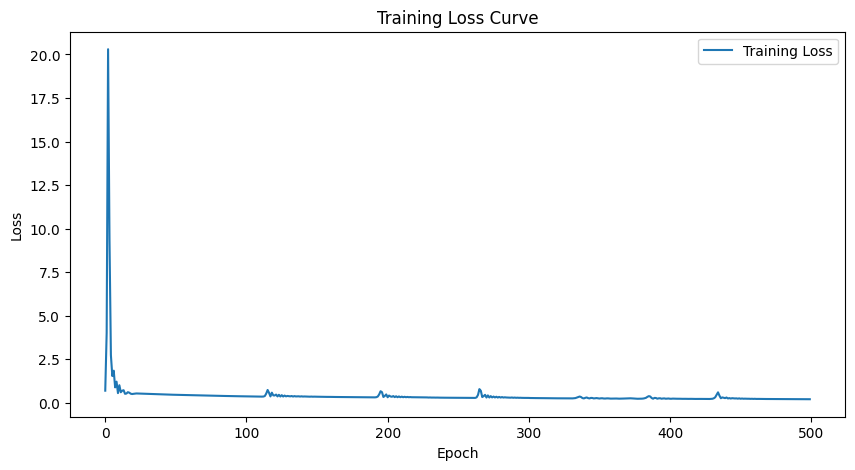

Best Model was saved at epoch 60 with accuracy 68.16%


In [16]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [17]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'.


In [18]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 68.16%
                  precision    recall  f1-score   support

    infringement       0.72      0.57      0.64       283
non_infringement       0.66      0.79      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.68      0.68       581



/tmp/ipykernel_1078087/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
